In [1]:
import json
import os
import re
from collections import Counter
import pandas as pd
import seaborn as sns
from pathlib import Path

from pydantic import ConfigDict

from src.data.make_dataset import CONSPIRACY_THEORIST_RE


In [2]:
comments = []
with open(os.path.join('../..', 'data', 'interim', 'RC_2009-09.jsonl'), encoding='utf8') as f:
    for line in f:
        comments.append(json.loads(line))

what is the distribution of subreddits labeling conspiracy theorists?

In [3]:
df = pd.DataFrame(Counter(map(lambda x: x['subreddit'], comments)).most_common())

In [4]:
df.columns=['subreddit', 'count']

In [5]:
df.head()

,subreddit,count
0,politics,63
1,reddit.com,52
2,AskReddit,37
3,conspiracy,30
4,science,25


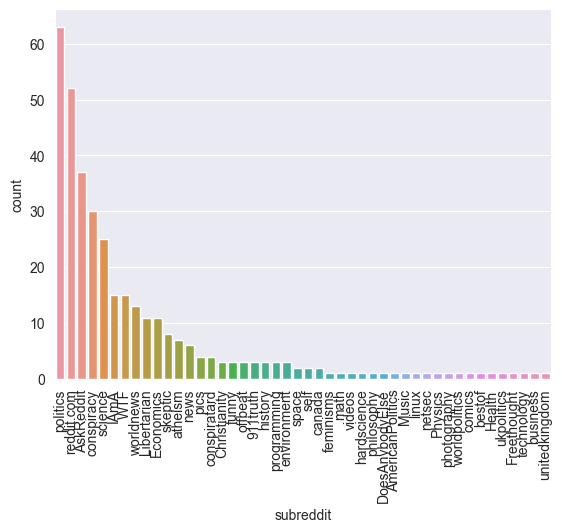

In [6]:
plt = sns.barplot(df, x='subreddit', y='count')
_=plt.set_xticklabels(plt.get_xticklabels(), rotation=90)

In [7]:
most_commmon_subreddits = df.sort_values('count', ascending=False).subreddit.head(5).values

In [8]:
comments_df = pd.DataFrame(comments)

In [9]:
comments_df.head()

,ups,parent_id,subreddit_id,distinguished,name,author_flair_text,created_utc,score_hidden,author_flair_css_class,retrieved_on,...,body,gilded,link_id,score,downs,author,id,edited,subreddit,controversiality
0,1,t1_c0cmwoy,t5_2qh4r,None,t1_c0cmxf5,None,1251767865,False,None,1426033725,...,"Think about it, you buffoon. You can't stop th...",0,t3_9ehvn,1,0,[deleted],c0cmxf5,True,conspiracy,0
1,5,t1_c0cmxpt,t5_2qh13,None,t1_c0cmyay,None,1251769251,False,None,1426033742,...,"Haha, let me show you how a conspiracy theoris...",0,t3_9fzox,5,0,BondsOfEarthAndFire,c0cmyay,False,worldnews,0
2,9,t3_9g0uk,t5_2qh0u,None,t1_c0cn6df,None,1251782883,False,None,1426033858,...,I always thought that driving the Google Stree...,0,t3_9g0uk,9,0,LieutenantClone,c0cn6df,False,pics,0
3,1,t1_c0cmxeo,t5_2qh6c,None,t1_c0cn6iy,None,1251783193,False,None,1426033860,...,"&gt;Start message boards about it, religiously...",0,t3_9fvfu,1,0,RexManningDay,c0cn6iy,True,Christianity,0
4,0,t1_c0cmtpn,t5_2qh63,None,t1_c0cncod,None,1251802766,False,None,1426034012,...,&gt;the conspiracy theorist in me wants to bel...,0,t3_9fwry,0,0,arguingwithidiots,c0cncod,False,Libertarian,0


In [10]:
def conspiracy_context(doc, context_half_length=50, total_length=100+len("conspiracy theorists")):
    wics = []
    doc = doc.replace('\n', '')

    for match in re.finditer(CONSPIRACY_THEORIST_RE, doc, flags=re.I | re.DOTALL | re.U | re.M):
        s, e = match.span()
        left_padding = " " * (context_half_length - (s - max(s-context_half_length, 0)))
        doc = left_padding+doc[max(s-context_half_length, 0):e+context_half_length]
        right_padding = ' '* (total_length- len(doc))
        doc += right_padding
        wics.append(doc)
    return wics


In [11]:
len(comments_df)

349

In [12]:
comments_df['label_in_context'] = comments_df.body.apply(conspiracy_context)

In [13]:
labels_df = comments_df.explode('label_in_context')

In [14]:
print('\n'.join(labels_df.sample(100)[['label_in_context', 'subreddit']].apply(lambda x:' '.join(x), axis=1)))

tually funny because if you notice you're a crazy conspiracy theorist.  No.                                              bestof
                                        Are you a conspiracy theorist sir?                                               skeptic
 nonsense with buzz words mixed in, crap that ufo/conspiracy theorists believe to be true.                               Physics
s give up and move on? Of course not. As with all conspiracy theorists, evidence *against* the conspiracy is evidence *  reddit.com
people willing to look further will be branded as conspiracy theorists. I fear the window is closing, or has closed alr  Libertarian
 was but I didn't exclude the possibility he is a conspiracy theorist.                                                   reddit.com
                                       God, those conspiracy theorists are fucking morons to say the least. If on Info   WTF
 a fair representation of the 9/11 truth movement/conspiracy theorists in general?          

In [15]:
grouped = labels_df.groupby('subreddit')
for subreddit in most_commmon_subreddits:
    group = grouped.get_group(subreddit)
    print(subreddit)
    print('\n'.join(group.label_in_context.sample(10)))
    print()

politics
                                                  Conspiracy theorists called this a long time ago.                     
s, because you're wrong.**How does that make me a conspiracy theorist? This isn't a conspiracy theory. This is establis 
event if this were not the case. i feel like most conspiracy theorists just get a hard on by looking at the pictures, a 
d expansion?) I am not an anarchist, a radical, a conspiracy theorist, or a reactionary.  I work in an establishment po 
                                 Look who are the conspiracy theorists now...                                           
 to him. He's exaggerating, because he's a reddit conspiracy theorist. The laws are actually different according to eac 
at she says she does, they will still call her a "conspiracy theorist" and blame her ideals on the right wing and glen  
 that most of the people who are die-hard vaccine conspiracy theorists are also rapid Truthers, Birthers, and Teabagger 
                       

observations:
* several comments use quotes
* relationship with pronouns seems a good indication of positive/negative connotation
* <ajd> conspiracy theorists seem interesting
* often mentioned as part of other groups like in "conspiracy theorists and freaks"

In [16]:
comments_df[comments_df.body.apply(lambda x: "You mean using the community of conspiracy theorists to show the trends in the community of" in x)]

,ups,parent_id,subreddit_id,distinguished,name,author_flair_text,created_utc,score_hidden,author_flair_css_class,retrieved_on,...,gilded,link_id,score,downs,author,id,edited,subreddit,controversiality,label_in_context
208,1,t1_c0d9wiz,t5_mouw,None,t1_c0d9wyn,None,1253214937,False,None,1426047793,...,0,t3_9lgxr,1,0,[deleted],c0d9wyn,True,science,0,[nspiracy as proof?You mean using the communit...


In [40]:
from riveter.riveter import Riveter

riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(comments_df.body,
             comments_df.index,
              )
persona_score_dict = riveter.get_score_totals()

100%|██████████| 349/349 [00:33<00:00, 10.49it/s]

2023-04-06 17:54:50 Complete!


In [41]:
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=True):
    print(round(_score, 3), '\t', _persona)

1.0 	 general electric
1.0 	 kings
1.0 	 the loudest, so easily led people
1.0 	 &gt;the conspirators
1.0 	 other star pieces
1.0 	 lisa
1.0 	 people's behavior
1.0 	 william buckley
1.0 	 clinton/bush
1.0 	 the author's pov
1.0 	 some mans recreation
1.0 	 the reasonistas
1.0 	 your lawyer
1.0 	 a bigger audience
1.0 	 my "driver's license number
1.0 	 reno
1.0 	 a couple voices
1.0 	 big pharma
1.0 	 all you
1.0 	 you idiot bloggers
1.0 	 theorist nut jobs
1.0 	 the founding fathers
1.0 	 the governor
1.0 	 palin
1.0 	 the harry potter series
0.556 	 mr bush, (after being slipped a truth drug) on what he was mandated to do


0.5 	 the pundits
0.5 	 the conspirators
0.5 	 the bankers
0.5 	 any downvotes
0.5 	 db2
0.5 	 hebrew characters
0.5 	 both sides
0.5 	 this guy
0.5 	 hams
0.5 	 alex jones himself
0.5 	 noam chomsky
0.5 	 _
0.5 	 barack obama
0.5 	 most girls
0.5 	 conspiracy theorist
0.5 	 the ss agent
0.5 	 the dude
0.5 	 howard hughs
0.5 	 the author
0.5 	 others
0.5 	 vaccin

F:\PycharmProjects\thrutherstoo\venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
F:\PycharmProjects\thrutherstoo\venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
F:\PycharmProjects\thrutherstoo\venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
f:\riveter-nlp\riveter\riveter.py:264: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and ma

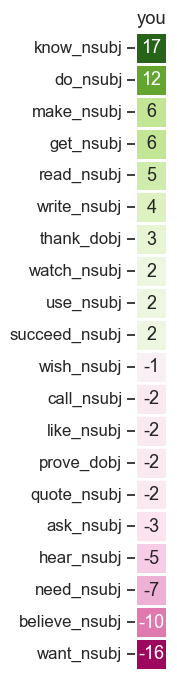

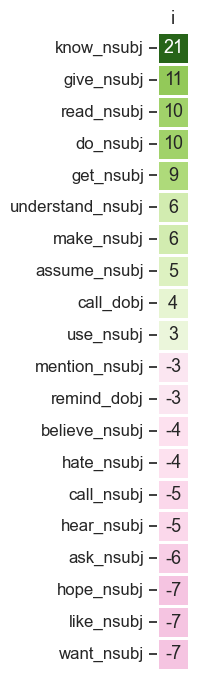

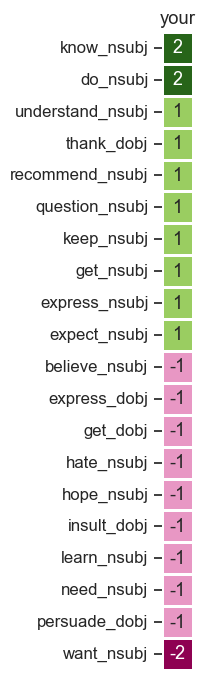

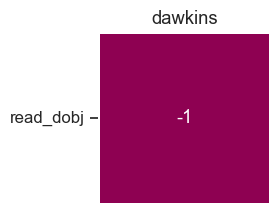

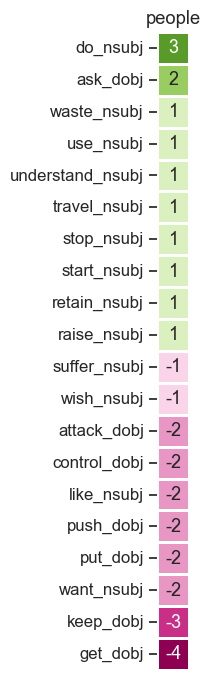

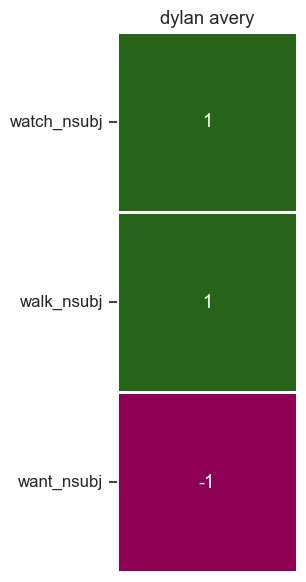

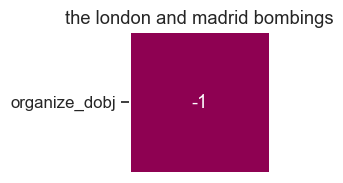

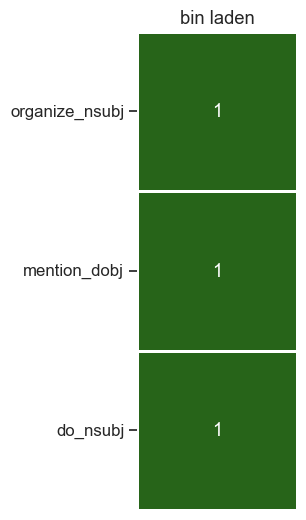

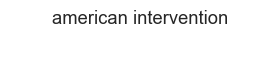

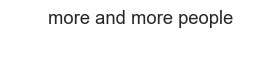

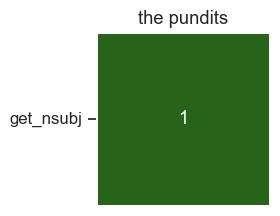

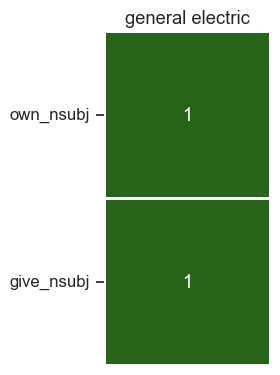

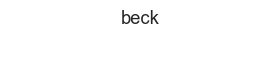

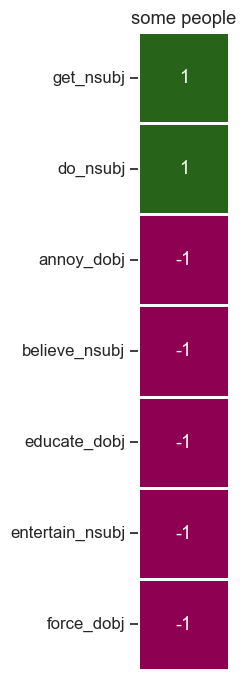

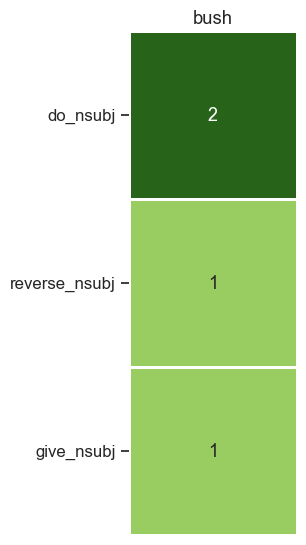

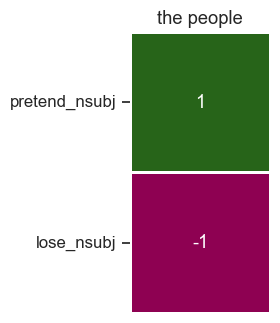

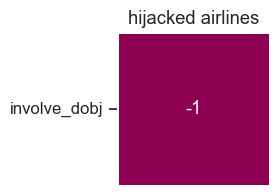

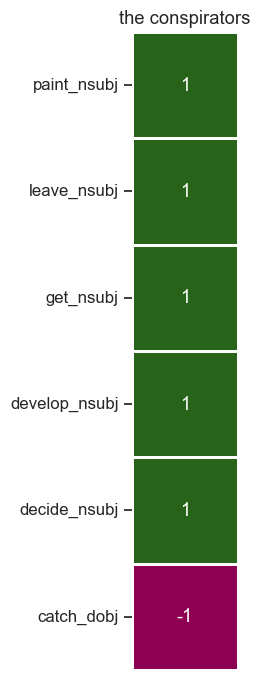

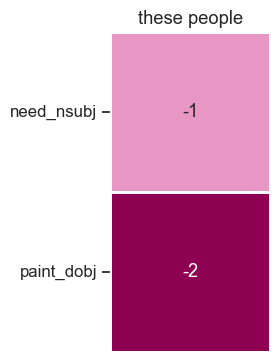

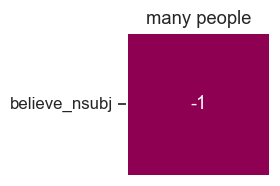

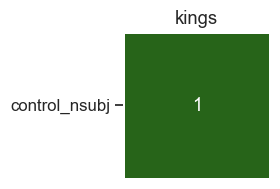

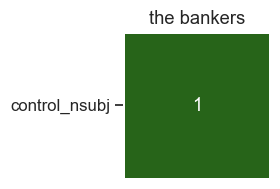

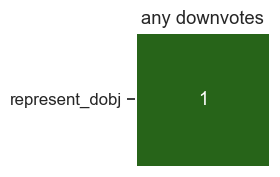

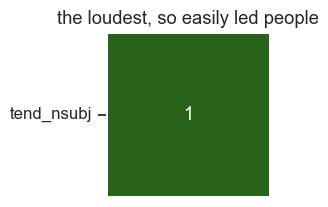

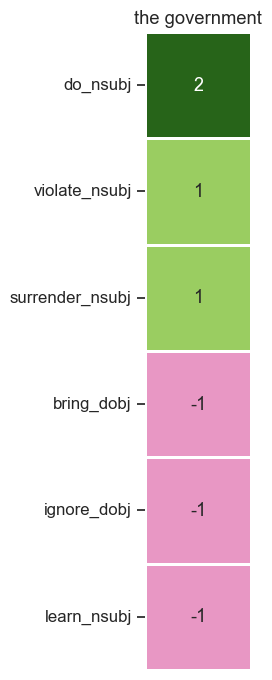

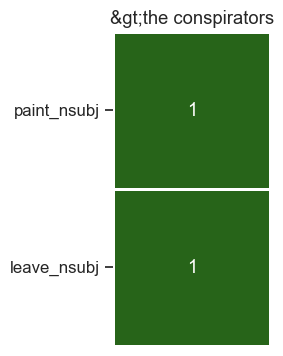

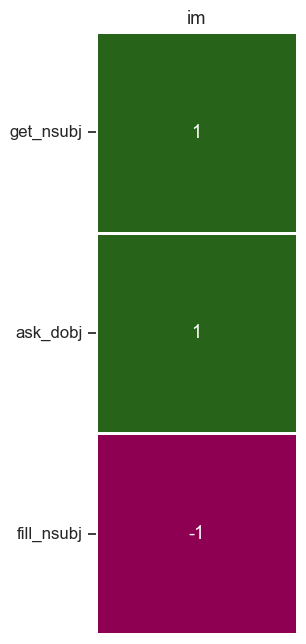

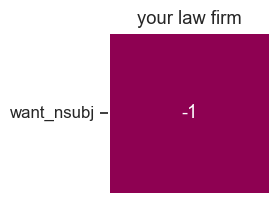

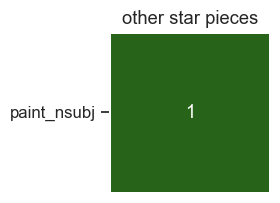

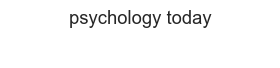

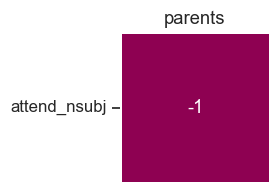

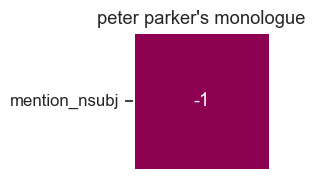

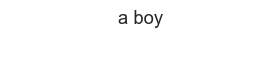

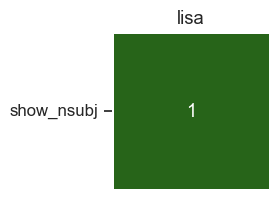

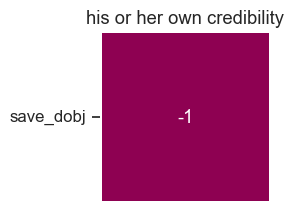

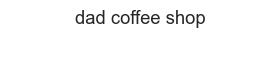

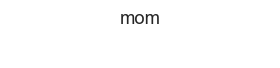

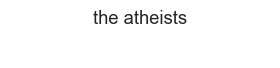

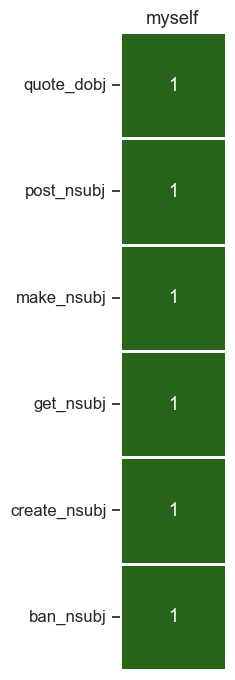

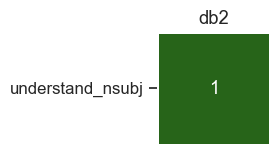

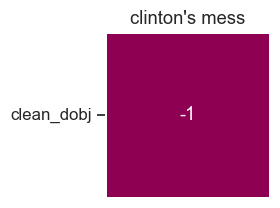

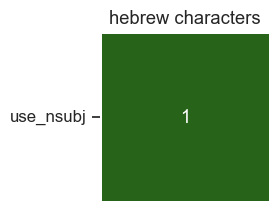

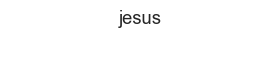

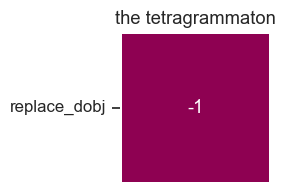

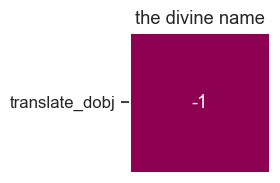

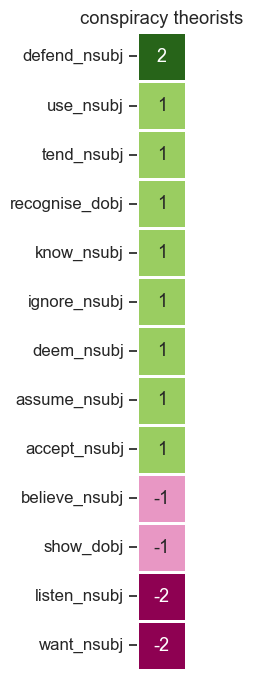

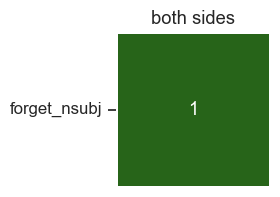

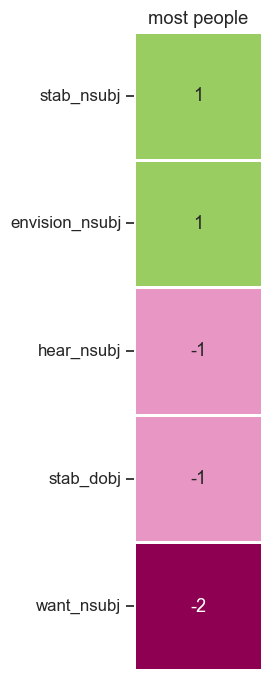

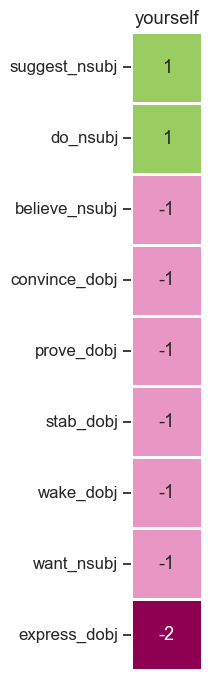

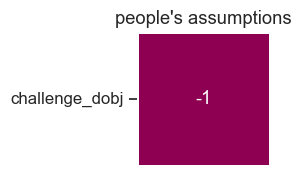

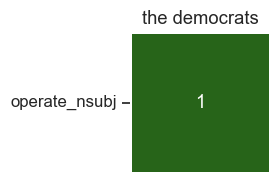

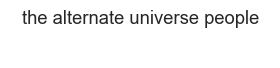

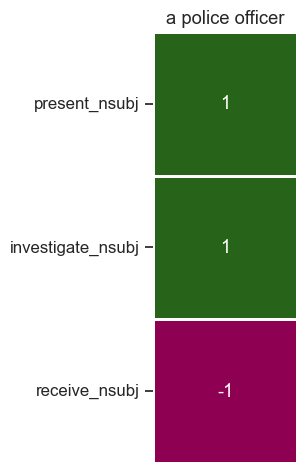

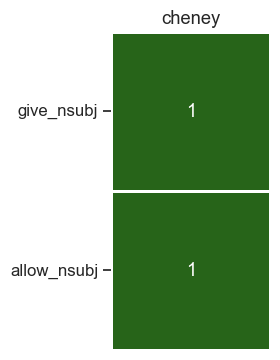

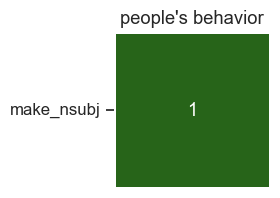

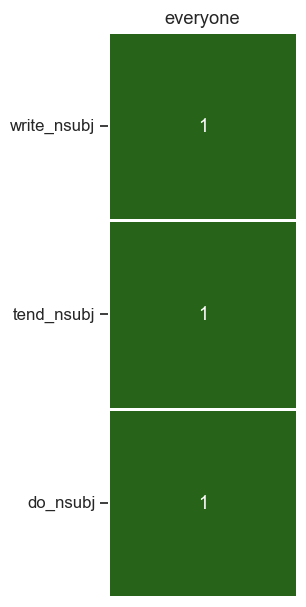

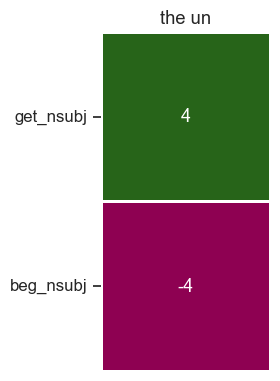

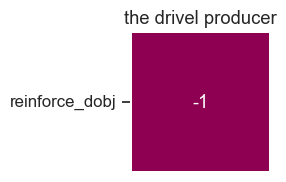

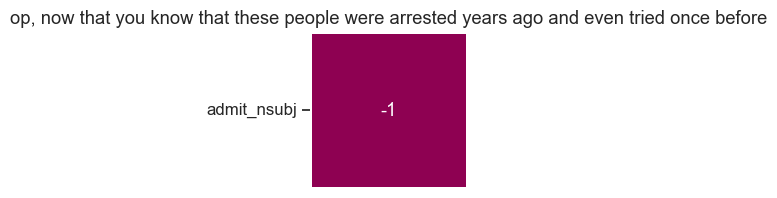

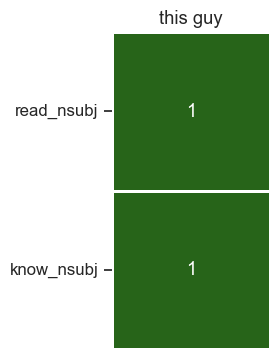

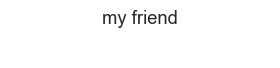

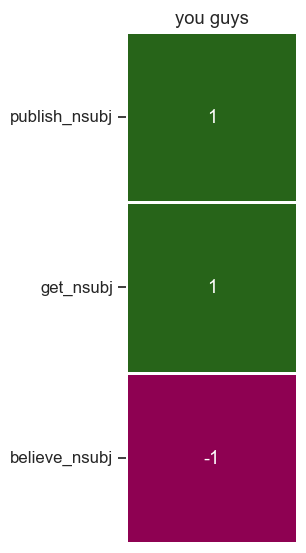

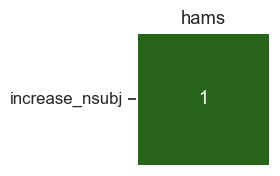

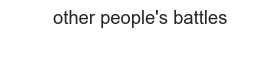

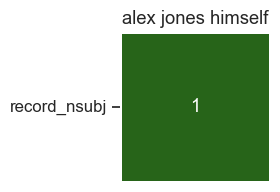

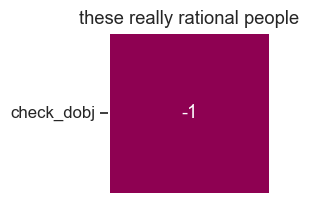

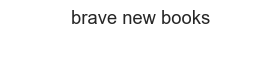

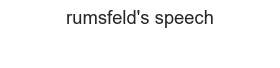

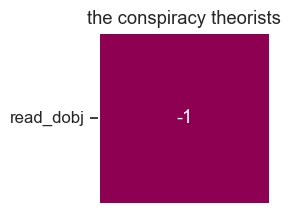

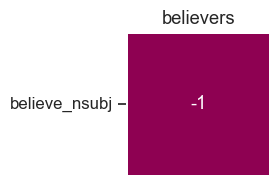

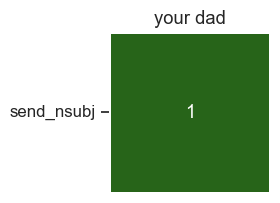

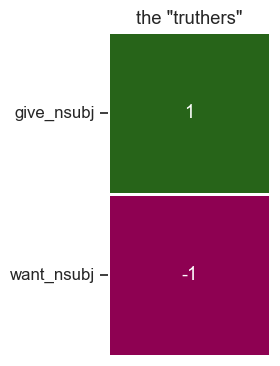

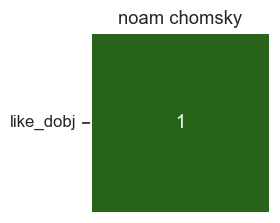

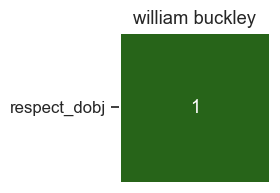

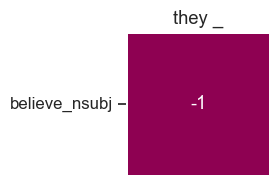

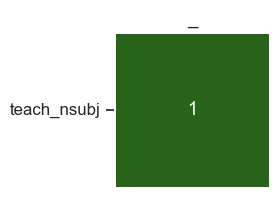

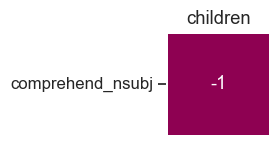

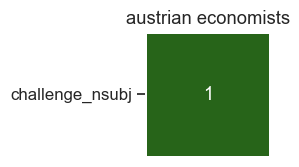

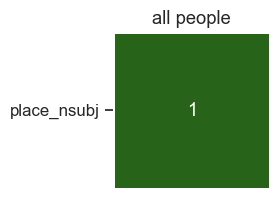

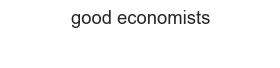

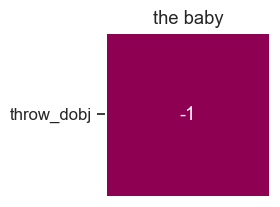

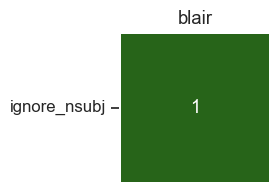

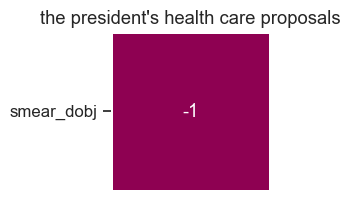

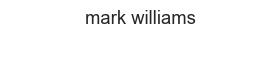

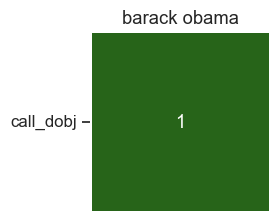

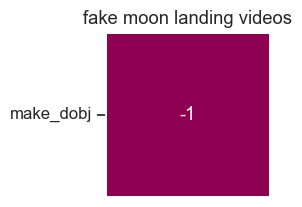

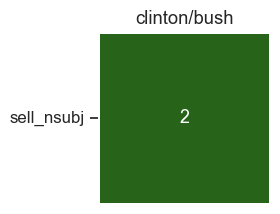

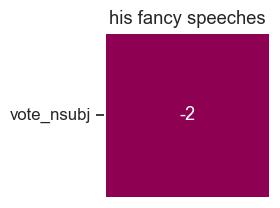

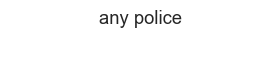

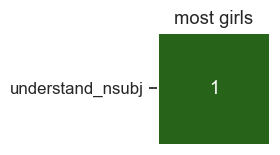

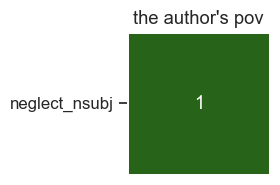

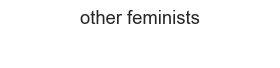

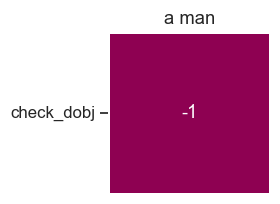

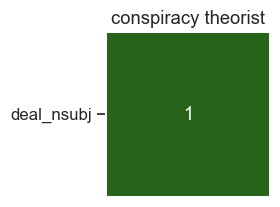

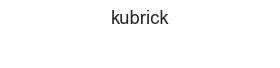

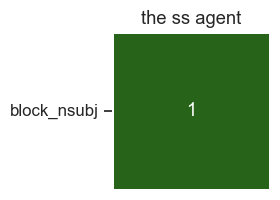

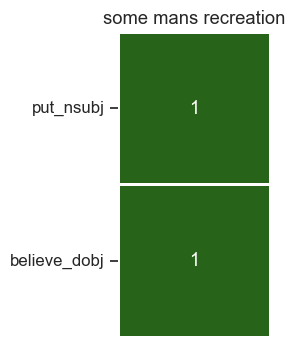

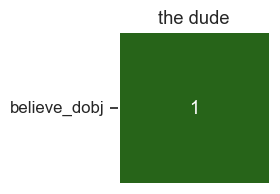

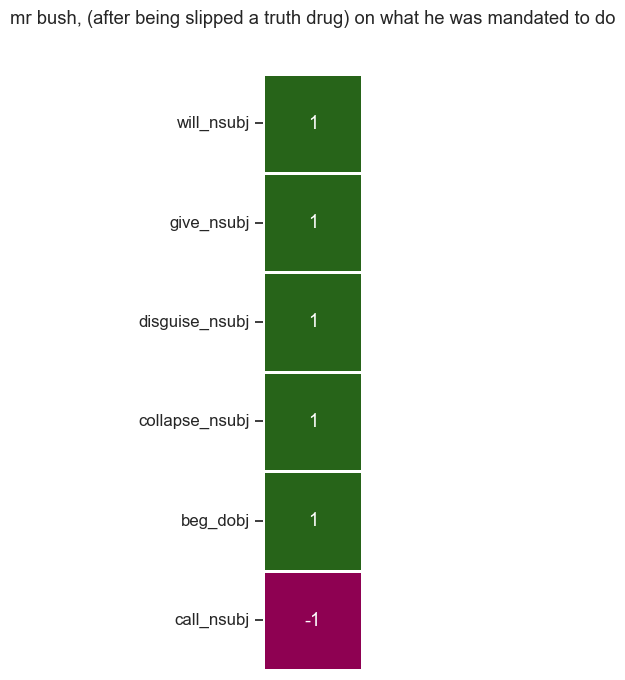

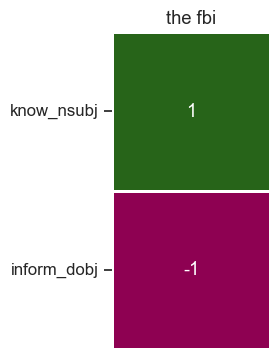

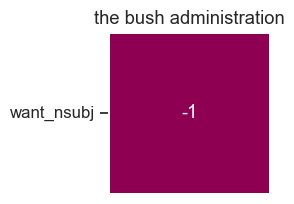

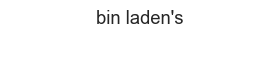

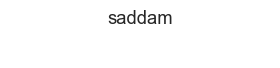

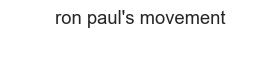

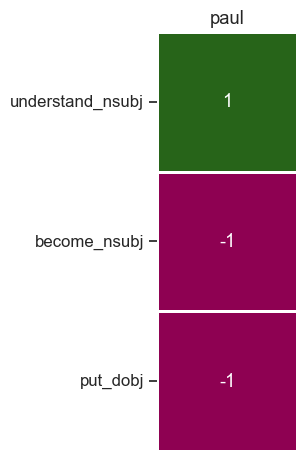

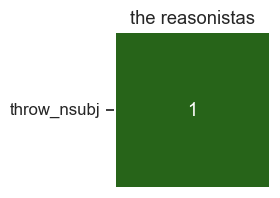

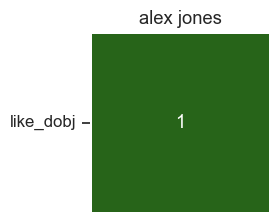

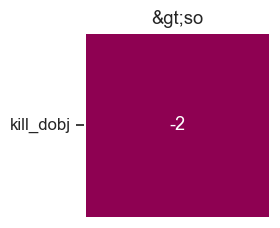

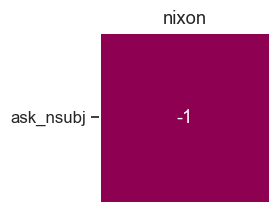

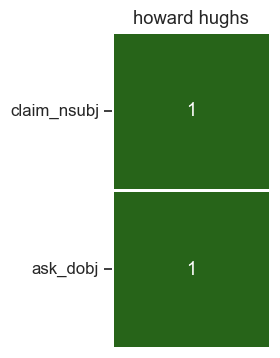

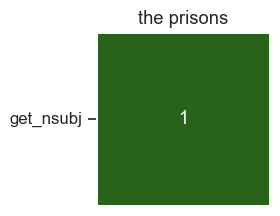

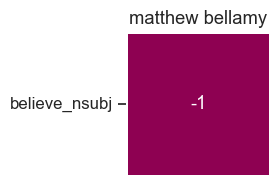

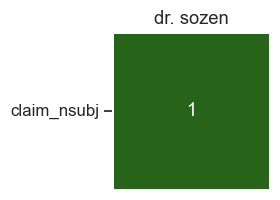

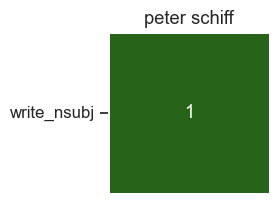

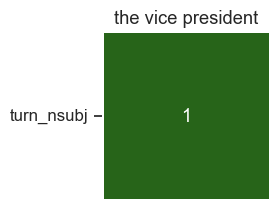

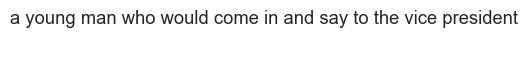

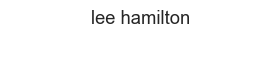

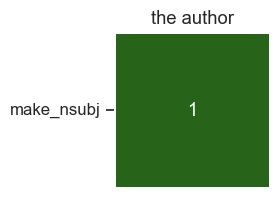

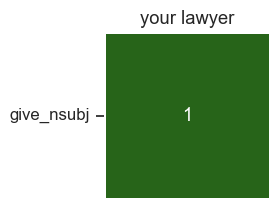

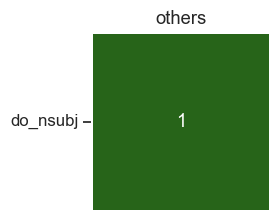

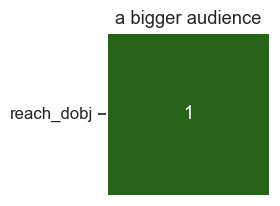

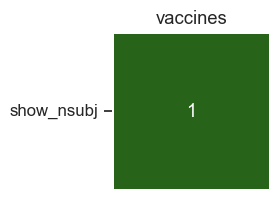

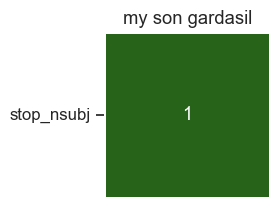

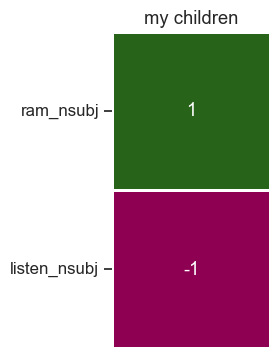

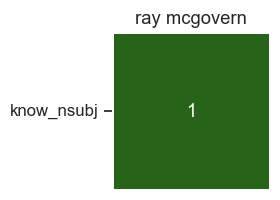

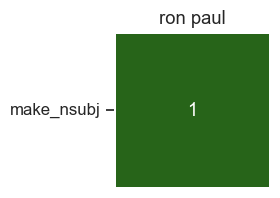

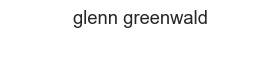

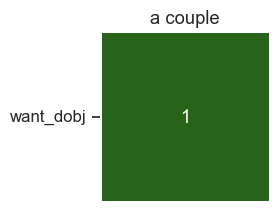

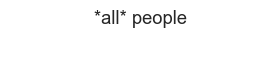

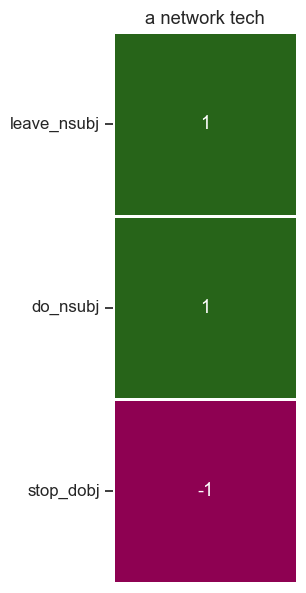

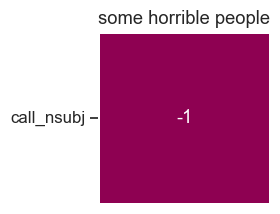

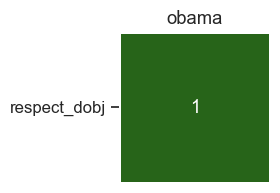

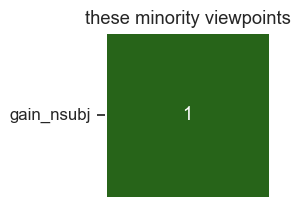

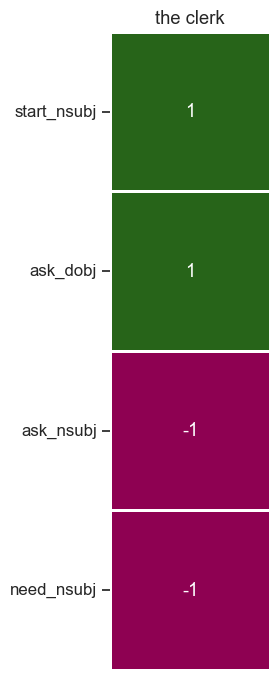

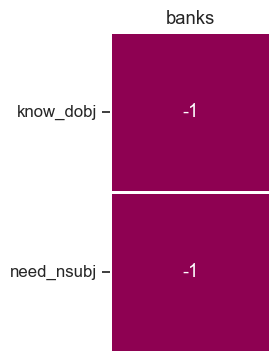

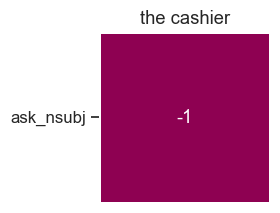

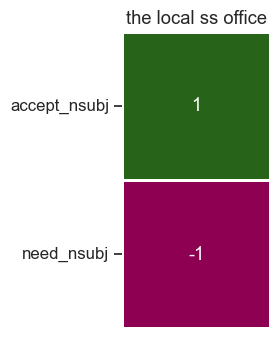

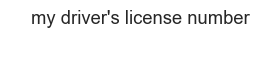

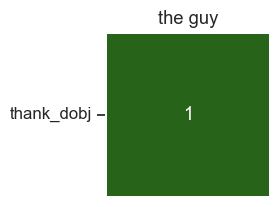

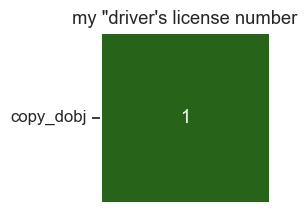

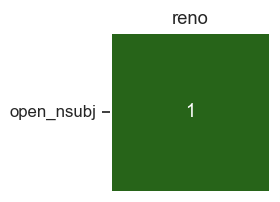

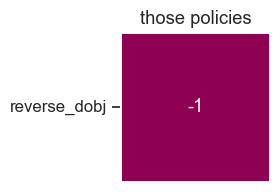

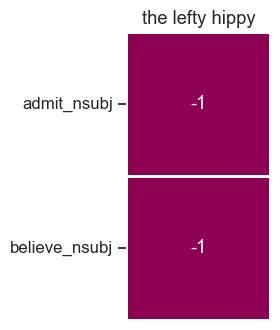

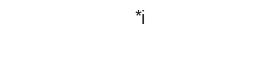

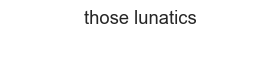

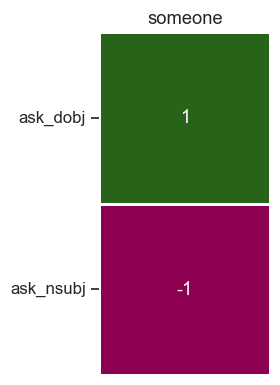

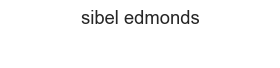

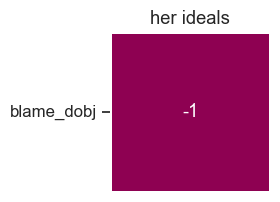

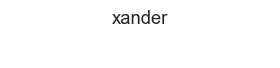

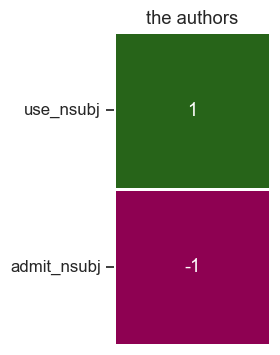

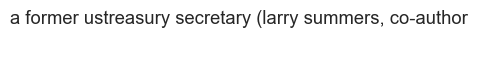

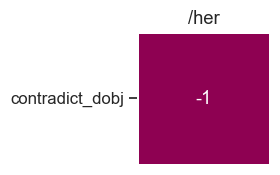

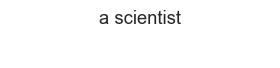

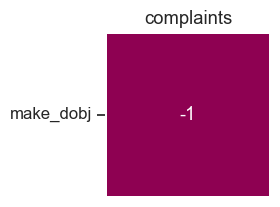

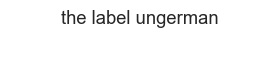

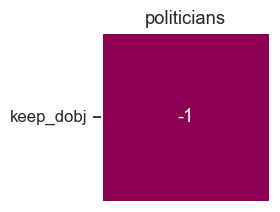

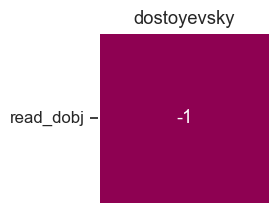

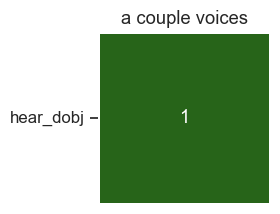

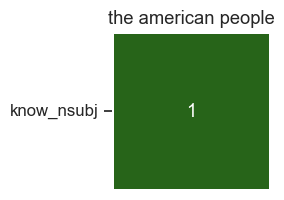

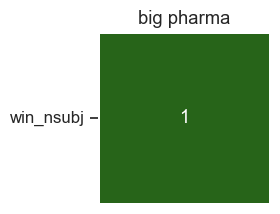

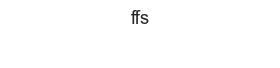

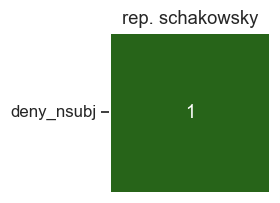

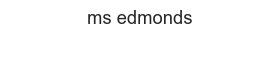

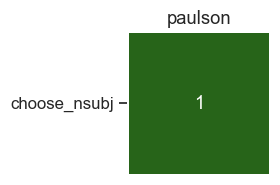

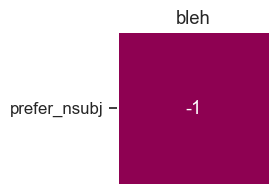

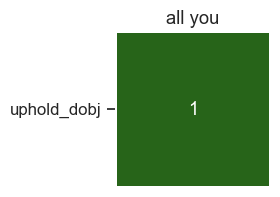

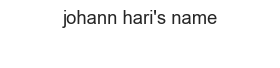

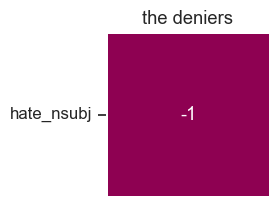

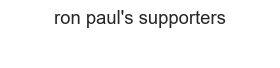

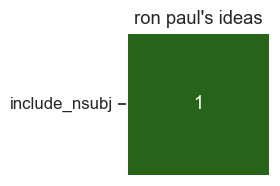

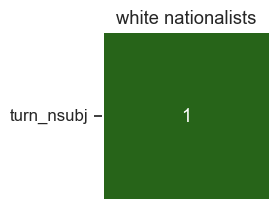

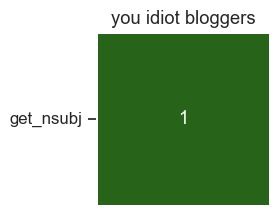

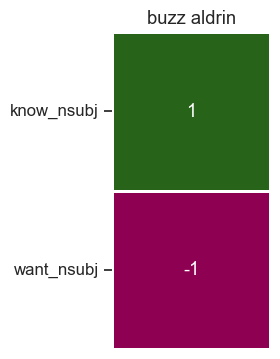

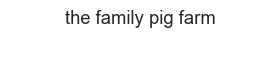

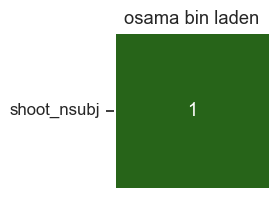

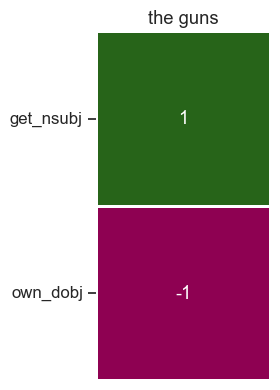

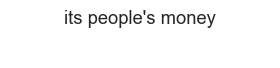

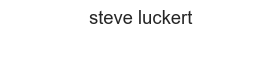

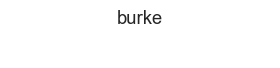

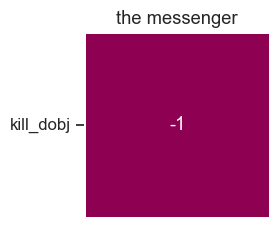

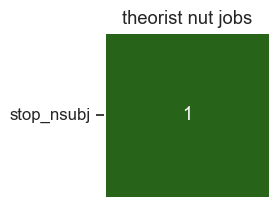

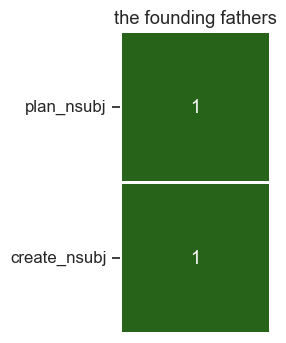

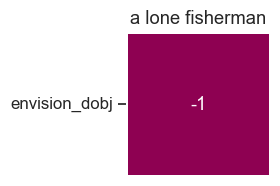

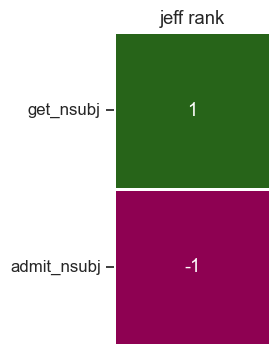

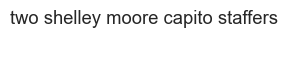

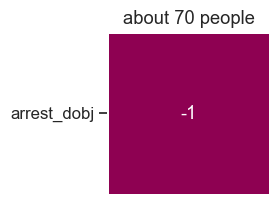

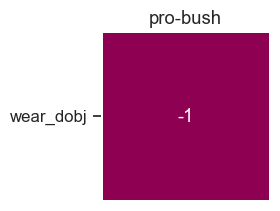

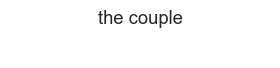

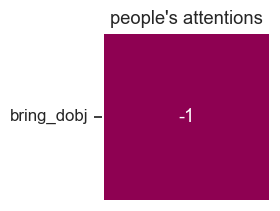

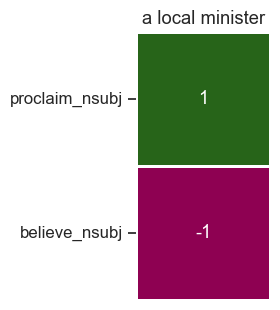

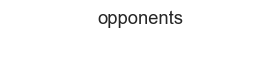

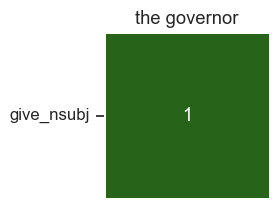

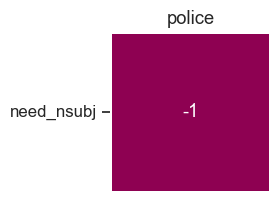

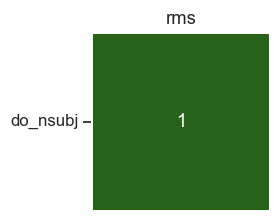

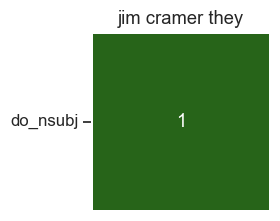

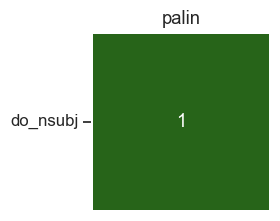

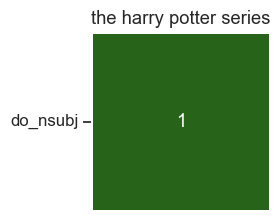

In [42]:
for persona in persona_score_dict:
    riveter.plot_verbs_for_persona(persona, figsize=(3,7))

In [43]:
persona_score_dict.keys()

dict_keys(['you', 'i', 'your', 'dawkins', 'people', 'dylan avery', 'the london and madrid bombings', 'bin laden', 'american intervention', 'more and more people', 'the pundits', 'general electric', 'beck', 'some people', 'bush', 'the people', 'hijacked airlines', 'the conspirators', 'these people', 'many people', 'kings', 'the bankers', 'any downvotes', 'the loudest, so easily led people', 'the government', '&gt;the conspirators', 'im', 'your law firm', 'other star pieces', 'psychology today', 'parents', "peter parker's monologue", 'a boy', 'lisa', 'his or her own credibility', 'dad coffee shop', 'mom', 'the atheists', 'myself', 'db2', "clinton's mess", 'hebrew characters', 'jesus', 'the tetragrammaton', 'the divine name', 'conspiracy theorists', 'both sides', 'most people', 'yourself', "people's assumptions", 'the democrats', 'the alternate universe people', 'a police officer', 'cheney', "people's behavior", 'everyone', 'the un', 'the drivel producer', 'op, now that you know that thes

In [44]:
persona_polarity_verb_count_dict = riveter.get_persona_polarity_verb_count_dict()

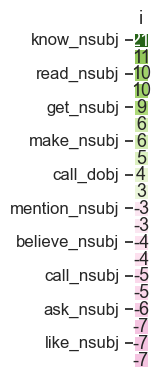

In [45]:

riveter.plot_verbs_for_persona('i', figsize=(2, 4))

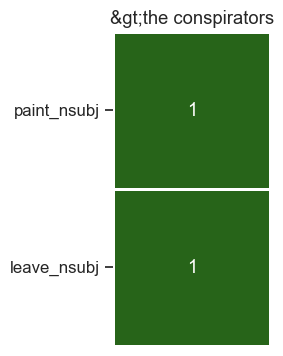

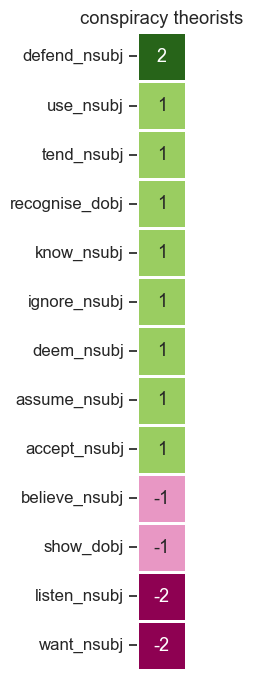

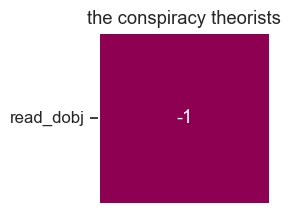

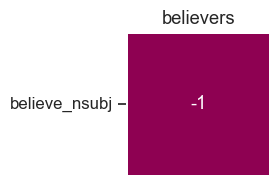

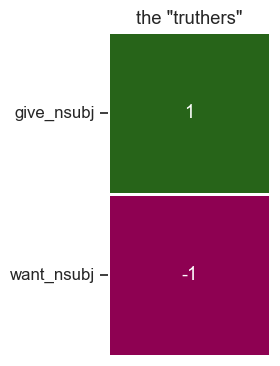

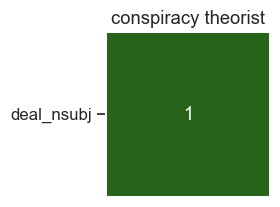

In [46]:
for persona in ['&gt;the conspirators', 'conspiracy theorists','the conspiracy theorists', 'believers','the "truthers"', 'conspiracy theorist',]:
    riveter.plot_verbs_for_persona(persona, figsize=(3,7))

In [51]:
from riveter.riveter import Riveter

riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(comments_df.body,
              comments_df.index,
              persona_patterns_dict={'third singular': r'^he$|^him$|^himself$|^she$|^her$|^herself$',
                                     'third plural': r'^they$|^them$|^themselves$',
                                     'conspiracy': CONSPIRACY_THEORIST_RE}
              )
persona_score_dict = riveter.get_score_totals()
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=True):
    print(round(_score, 3), '\t', _persona)


100%|██████████| 349/349 [00:31<00:00, 10.92it/s]

2023-04-06 17:57:00 Complete!
0.143 	 third singular
0.053 	 third plural
0.042 	 conspiracy


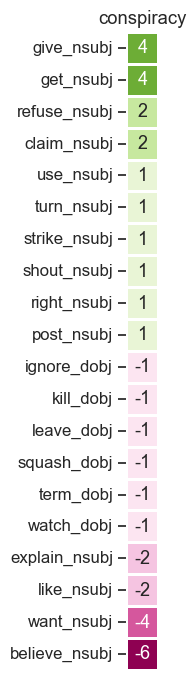

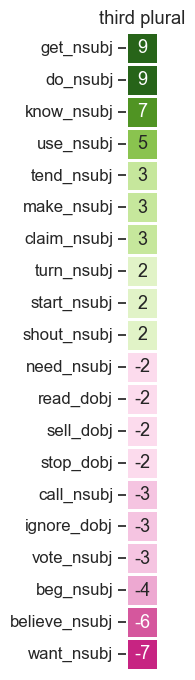

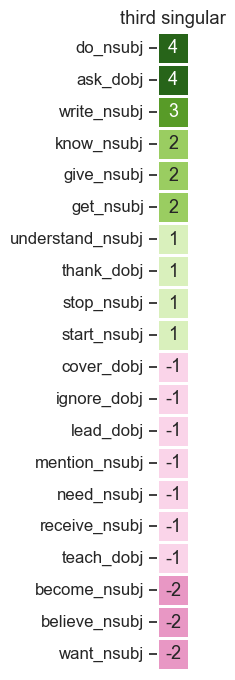

In [52]:
for persona in persona_score_dict:
    riveter.plot_verbs_for_persona(persona, figsize=(3, 7), output_path=f'../../reports/figures/{persona}_connotation.pdf')

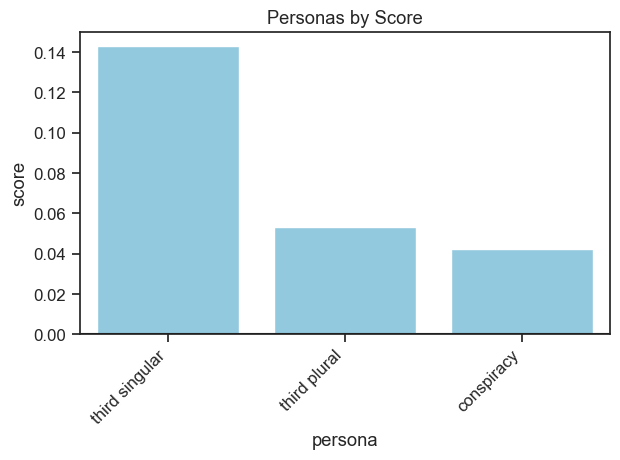

In [53]:
riveter.plot_scores()

In [ ]:
# riveter.save('test')